This notebook takes in all of the operator features, creates some final ones, and then runs them through an ensemble anomaly detection model. It outputs outlier probabilities for all wallets but also outputs a file of the top candidates for consideration as cheaters. 

In [1]:
import pandas as pd, numpy as np, datetime as dt
import sklearn, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

data = pd.read_pickle('operatorDataTx.pkl') # from OperatorDataFinal.ipynb

In [2]:
#add average pay per node feature
data['avgPayPerNode']=data.apply(lambda x: x['avgMonthPay']/x['unique_nodes'],axis=1)

In [3]:
#add feature that counts the number of days the node operator has been operational
daysInService = data.apply(lambda x: pd.to_datetime('2021-04-30').date()-x['earliestNodeCreated'],axis=1)
data['daysInService']=daysInService.dt.days

In [4]:
data[data.maxPieceCount==0].loc[2291,:].T

wallet                          0x6ded65b4a912764b26d288bf740ac8e784b8c958
unique_nodes                                                             1
minAuditReputation                                                       1
avgAuditReputation                                                       1
maxAuditReputation                                                       1
minFreeDisk                                                          8e+12
avgFreeDisk                                                          8e+12
maxFreeDisk                                                          8e+12
minPieceCount                                                            0
avgPieceCount                                                            0
maxPieceCount                                                            0
earliestNodeCreated                                             2020-11-28
mostRecentNodeCreated                                           2020-11-28
fullWalletList           

In [5]:
#add avgMonthPay/avgPieceCount
data['relPieceToPay'] = data.apply(lambda x: x['avgPieceCount']/x['avgMonthPay'],axis=1)

In [6]:
#one-hot encode the type column
onehot_types = pd.get_dummies(data['type'], prefix='type')
data = data.drop('type',axis=1).merge(onehot_types,left_index=True, right_index=True)

In [7]:
#include a column that reflects shift in payments from Feb to March
data['marchShift']=data['2021-03-01']-data['2021-02-01']
#include proportions of unique in- and out-bound transactions to their totals
data['uniqOutboundProp'] = data.apply(lambda x: x['uniqueOutbound']/x['numOutbound'] if x['numOutbound']>0 else 0,axis=1)
data['uniqInboundProp'] = data.apply(lambda x: x['uniqueInbound']/x['numInbound'] if x['numInbound']>0 else 0, axis=1)

**subset, standardize, and normalize data**
DBSCAN and LOF don't work well at higher dimension (>20). When I tried using DBSCAN on the full 25-feature set (cols1 below), it found more noise than signal, so the results weren't usable. 
So for DBSCAN and LOF, I have a subset of our subset (cols2) that uses only 17 features.

In [8]:
cols1 = ['wallet', 'unique_nodes', 'avgAuditReputation',
       'avgFreeDisk', 'maxPieceCount', 
       'numAssocWallets', 'numAssocEmails',
       'avgMonthPay',  'numOutbound','tokenTypes',
       'numInbound','numAssoc', 'marchShift',
       'uniqOutboundProp', 'uniqInboundProp','avgPayPerNode', 'daysInService','relPieceToPay']

cols2 = []

In [9]:
data = data.reset_index(drop=True)
X = data[cols1]
#Xsub = data[cols2]

In [10]:
# Scaling the data to make sure no extreme values exert undue influence
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.iloc[:,1:])
#Xsub_scaled = scaler.fit_transform(Xsub.iloc[:,1:])

In [11]:
#Force into normal distribution
X_normalized = normalize(X_scaled)
#Xsub_normalized = normalize(Xsub_scaled)

In [12]:
#convert back to dataframe
X_normalized = pd.DataFrame(X_normalized)
#Xsub_normalized = pd.DataFrame(Xsub_normalized)

In [13]:
#create separate adjuster function for algos form the pyod package, where anomalies are marked 1 instead of -1
#here, any anomaly that doesn't meet the threshold gets assigned -1
def adjusterPyod(x,outputCol):
    if x[outputCol] != 1:
        return 0
    elif ((x[7]>20) or (x[7]>10 and x[11]>0)):
        return 1
    else:
        return -1

**Ensemble**

In [14]:
def runModels(ensembleList):
    for item in ensembleList:
        item.fit(X_normalized)

In [15]:
from pyod.models.iforest import IForest
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.copod import COPOD
from pyod.models.cblof import CBLOF
from pyod.models.rod import ROD
from pyod.models.ocsvm import OCSVM
from pyod.models.knn import KNN
contam = .05
rodModel = ROD(contamination = contam)
ocsvmModel = OCSVM(contamination = contam)
#cblofModel = CBLOF(contamination = contam) 
knnModel = KNN(contamination=contam, metric='mahalanobis', metric_params={'V': np.cov(X_normalized.T)})
copodModel = COPOD(contamination = contam)
iforestModel = IForest(n_estimators=200,max_samples=len(X),contamination = contam, max_features=4)
aeModel = AutoEncoder(hidden_neurons=[12,12],contamination = contam)

#run ensemble
from pyod.models.lscp import LSCP
from combo.models.score_comb import aom as combo_aom
from combo.models.score_comb import moa as combo_moa
from combo.models.score_comb import average as combo_average
from combo.models.score_comb import maximization as combo_maximization
from combo.models.score_comb import majority_vote as combo_majority_vote
from combo.models.score_comb import median as combo_median

lscpModel = LSCP(detector_list=[knnModel, rodModel, aeModel, ocsvmModel, iforestModel, copodModel],contamination = .05)
lscpModel.fit(X_normalized)
#X['LSCP']= lscpModel.predict(X_normalized)
#X['LSCPadj'] = X.apply(lambda x: adjusterPyod(x, len(X.columns)-1), axis=1)

#X['LSCPadj'].value_counts()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 17)                306       
_________________________________________________________________
dropout (Dropout)            (None, 17)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                306       
_________________________________________________________________
dropout_1 (Dropout)          (None, 17)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 12)                216       
_________________________________________________________________
dropout_2 (Dropout)          (None, 12)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1

C:\ProgramData\Miniconda3\lib\site-packages\pyod\models\lscp.py:384: UserWarning: The number of histogram bins is greater than the number of classifiers, reducing n_bins to n_clf.
  "The number of histogram bins is greater than the number of "
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 0    5053
-1     194
 1      63
Name: LSCPadj, dtype: int64

In [ ]:
X['KNN']=knnModel.predict(X_normalized)
X['KNN_score']=knnModel.decision_scores_
X['ROD']=rodModel.predict(X_normalized)
X['ROD_score']=rodModel.decision_scores_
X['AE']=aeModel.predict(X_normalized)
X['AE_score']=aeModel.decision_scores_
X['OCSVM']=ocsvmModel.predict(X_normalized)
X['OCSVM_score']=ocsvmModel.decision_scores_
X['ISOFOREST']=iforestModel.predict(X_normalized)
X['ISOFOREST_score']=iforestModel.decision_scores_
X['COPOD']=copodModel.predict(X_normalized)
X['COPOD_score']=copodModel.decision_scores_

In [29]:
X.columns

Index(['wallet', 'unique_nodes', 'avgAuditReputation', 'avgFreeDisk',
       'maxPieceCount', 'numAssocWallets', 'numAssocEmails', 'avgMonthPay',
       'numOutbound', 'tokenTypes', 'numInbound', 'numAssoc', 'marchShift',
       'uniqOutboundProp', 'uniqInboundProp', 'avgPayPerNode', 'daysInService',
       'relPieceToPay', 'LSCP', 'LSCPadj', 'KNN', 'KNN_score', 'ROD',
       'ROD_score', 'AE', 'AE_score', 'OCSVM', 'OCSVM_score', 'ISOFOREST',
       'ISOFOREST_score', 'COPOD', 'COPOD_score', 'LSCP_score'],
      dtype='object')

In [ ]:
#Before running this, change adjusterPyod so that the final else clause returns 0 instead of -1
X['KNNadj']= X.apply(lambda x: adjusterPyod(x, 20), axis=1)
X['RODadj']= X.apply(lambda x: adjusterPyod(x, 22), axis=1)
X['AEadj']= X.apply(lambda x: adjusterPyod(x, 24), axis=1)
X['OCSVMadj']= X.apply(lambda x: adjusterPyod(x, 26), axis=1)
X['ISOFORESTadj']= X.apply(lambda x: adjusterPyod(x, 28), axis=1)
X['COPODadj']= X.apply(lambda x: adjusterPyod(x, 30), axis=1)

In [16]:
X['LSCP_score']=lscpModel.decision_scores_

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [188]:
X['LSCP'] = X.apply(lambda x: 1 if x['LSCP_score']>lscpModel.threshold_ else 0,axis=1)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [189]:
X['LSCPadj'] = X.apply(lambda x: adjusterPyod(x, 18), axis=1)


C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [128]:
lscpModel.threshold_

1.682027015301688

(array([1.420e+02, 6.690e+02, 1.188e+03, 1.194e+03, 8.440e+02, 5.850e+02,
        3.170e+02, 1.850e+02, 8.000e+01, 4.800e+01, 2.200e+01, 1.200e+01,
        7.000e+00, 8.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00]),
 array([-1.65889025, -1.21326703, -0.76764381, -0.3220206 ,  0.12360262,
         0.56922584,  1.01484906,  1.46047227,  1.90609549,  2.35171871,
         2.79734193,  3.24296514,  3.68858836,  4.13421158,  4.5798348 ,
         5.02545801,  5.47108123,  5.91670445,  6.36232767,  6.80795088,
         7.2535741 ,  7.69919732,  8.14482054,  8.59044375,  9.03606697,
         9.48169019,  9.92731341, 10.37293662, 10.81855984, 11.26418306,
        11.70980628, 12.15542949, 12.60105271, 13.04667593, 13.4

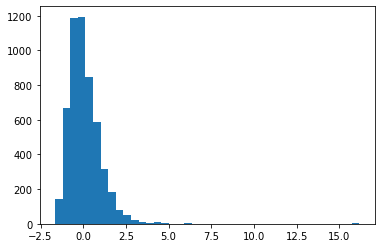

In [19]:
#Check if distribution of scores looks Gaussian
plt.hist(X.LSCP_score, bins=40)

In [235]:
#Calculate probability of being an outlier as the cdf of the LSCP score
from scipy.stats import norm
X['prob'] = norm.cdf(X.LSCP_score)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [218]:
X['prob'] = X.apply(lambda x: x['prob'] if x['LSCPadj']!=-1 else 0, axis=1)

C:\ProgramData\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [219]:
checker = X[['wallet','LSCP_score','LSCP', 'LSCPadj','prob']]

In [220]:
checker.loc[:100,:]

,wallet,LSCP_score,LSCP,LSCPadj,prob
0,0x000000000c7c9cbb8485c5e38c6c0da6a1017c1f,0.931822,0,0,0.824286
1,0x000000043dc3052d771845a71efc05b67f40abb4,-0.578138,0,0,0.281585
2,0x00083c3ae5730507fa39a90220df704c09cf124d,0.040648,0,0,0.516212
3,0x000e4b8d275cbe6af5c01a73bab484282317d8bb,1.794154,1,-1,0.000000
4,0x00101a0e98ecea02681a5447c3cab0c787d109f6,0.032456,0,0,0.512946
5,0x0010eb837063ab66d2179887e84402cda8c6baea,-0.548492,0,0,0.291677
6,0x00133dcda2946722de0f25e6ecfab53d12a06062,-0.023146,0,0,0.490767
7,0x0017ceed8eb8fc7977c55dce6b0dc3ffe8f4d184,-0.433736,0,0,0.332240
8,0x002b5274208de2c4efea9382558884d9ef97d557,-0.984301,0,0,0.162484
9,0x002bfafd32dc18c6588b704139b2fa495acab529,0.167519,0,0,0.566519


In [236]:
X.columns

Index(['wallet', 'unique_nodes', 'avgAuditReputation', 'avgFreeDisk',
       'maxPieceCount', 'numAssocWallets', 'numAssocEmails', 'avgMonthPay',
       'numOutbound', 'tokenTypes', 'numInbound', 'numAssoc', 'marchShift',
       'uniqOutboundProp', 'uniqInboundProp', 'avgPayPerNode', 'daysInService',
       'relPieceToPay', 'LSCP', 'LSCPadj', 'LSCP_score', 'prob'],
      dtype='object')

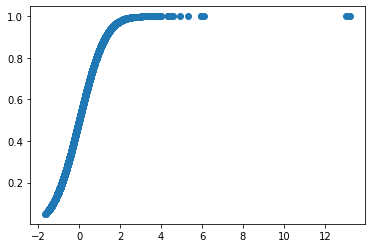

In [238]:
plt.scatter(X.LSCP_score, X.prob)

In [224]:
X[X.LSCPadj==1].to_pickle('candidateDF2.pkl')

C:\ProgramData\Miniconda3\lib\site-packages\pandas\core\frame.py:4164: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [2]:
#Save a csv version
X[X.LSCPadj==1].to_csv('clustering_candidate65.csv')

In [239]:
#Save version with limited fields
X[['wallet','LSCP_score','avgMonthPay','prob']].to_csv('LSCPoutputFinal.csv')